In [88]:
import cv2
import mediapipe as mp
import os
import json
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [89]:
import cv2
import mediapipe as mp
import numpy as np
import os
import json

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils

# Function to count steps based on foot placement changes
def count_steps(foot_landmarks):
    """
    Counts the number of steps taken based on both feet's vertical (y-axis) displacement.
    A step is counted when either foot moves up and down in a cyclic pattern.
    """
    step_count = 0
    prev_right_y, prev_left_y = None, None

    for frame in foot_landmarks:
        right_foot_y, left_foot_y = frame[0][1], frame[1][1]

        # Detect foot moving up for right foot
        if prev_right_y is not None and right_foot_y < prev_right_y:
            step_count += 0.5

        # Detect foot moving up for left foot
        if prev_left_y is not None and left_foot_y < prev_left_y:
            step_count += 0.5

        prev_right_y, prev_left_y = right_foot_y, left_foot_y

    return round(step_count)

# Paths for the stage 1 videos and keypoints storage
stage_path = "/Users/danyukezz/Desktop/2 year 1 semester/team project/danya_preprocessing_sports/hurdling/stages/stage1/videos"
keypoints_folder = "/Users/danyukezz/Desktop/2 year 1 semester/team project/danya_preprocessing_sports/hurdling/stages/stage1/keypoints"

# Ensure keypoints folder exists
os.makedirs(keypoints_folder, exist_ok=True)

for file in os.listdir(stage_path):
    if file.endswith(".mp4"):
        video_file_path = os.path.join(stage_path, file)
        cap = cv2.VideoCapture(video_file_path)

        keypoints_data = []  # Store keypoints for this video
        frame_count = 0
        foot_positions = []  # Store foot landmarks for counting steps

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            frame_count += 1

            # Convert frame to RGB for MediaPipe processing
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            result = pose.process(frame_rgb)

            if result.pose_landmarks:
                landmarks = result.pose_landmarks.landmark

                # Extract foot keypoints for step analysis
                right_foot = [landmarks[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX].x,
                              landmarks[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX].y]
                left_foot = [landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].x,
                             landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].y]

                foot_positions.append([right_foot, left_foot])

                # Store data for this frame
                keypoints_data.append({
                    "frame": frame_count,
                    "right_foot": right_foot,
                    "left_foot": left_foot
                })

        # Release the video
        cap.release()

        # Count the number of steps detected
        total_steps = count_steps(foot_positions)

        # Save keypoints and step count to the keypoints folder
        json_filename = os.path.splitext(file)[0] + "_keypoints.json"
        json_path = os.path.join(keypoints_folder, json_filename)
        with open(json_path, "w") as json_file:
            json.dump({"steps": total_steps, "keypoints": keypoints_data}, json_file, indent=4)

print("Step count analysis complete! JSON files saved in 'keypoints' folder.")

I0000 00:00:1737656458.725817 9764293 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1737656458.788065 10101235 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737656458.799043 10101235 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Step count analysis complete! JSON files saved in 'keypoints' folder.


In [90]:
import os
import json
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Path to the keypoints folder for step analysis
keypoints_folder = "/Users/danyukezz/Desktop/2 year 1 semester/team project/danya_preprocessing_sports/hurdling/stages/stage1/keypoints"

# Lists to store sequences and labels
sequences = []
labels = []

# Process keypoint JSON files
for file in os.listdir(keypoints_folder):
    if file.endswith("_keypoints.json"):
        file_path = os.path.join(keypoints_folder, file)
        with open(file_path, "r") as f:
            data = json.load(f)

        # Extract step count indicator from the JSON
        steps = data.get("steps", 0)  # Get step count (default to 0 if not found)
        keypoints = data.get("keypoints", [])

        # Ensure left and right foot counts are considered separately
        right_foot_steps = sum(1 for k in keypoints if k["right_foot"][1] < k["left_foot"][1])
        left_foot_steps = sum(1 for k in keypoints if k["left_foot"][1] < k["right_foot"][1])

        # Store both left and right foot step counts
        sequences.append([right_foot_steps, left_foot_steps])

        # Extract label from filename (assumes label is the first part of filename)
        try:
            label = float(file.split("_")[0])  # Modify if filename structure differs
        except ValueError:
            print(f"Warning: Unable to extract label from {file}")
            continue
        
        labels.append(label)
        print(labels)

# Pad sequences to ensure uniform input shape
if sequences:
    max_len = max(len(seq) for seq in sequences)
    sequences = pad_sequences(sequences, maxlen=max_len, padding='post', dtype='float32')
    labels = np.array(labels)

    print(f"Loaded {len(sequences)} sequences with labels.")
else:
    print("No sequences found in the keypoints folder.")

[1.0]
[1.0, 0.0]
[1.0, 0.0, 1.0]
[1.0, 0.0, 1.0, 0.0]
[1.0, 0.0, 1.0, 0.0, 1.0]
[1.0, 0.0, 1.0, 0.0, 1.0, 0.0]
[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0]
[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0]
Loaded 8 sequences with labels.


In [95]:
def augment_data(sequence):
    augmented_sequences = []

    # Original
    augmented_sequences.append(sequence)

    # Mirrored (flip angles horizontally)
    mirrored = -sequence
    augmented_sequences.append(mirrored)

    # Rotation (add a small angle offset)
    rotated = sequence + np.random.uniform(-10, 10, size=sequence.shape)
    augmented_sequences.append(rotated)

    # Noise (add random Gaussian noise)
    noisy = sequence + np.random.normal(0, 0.05, size=sequence.shape)
    augmented_sequences.append(noisy)

    # Scaled (adjust by a small percentage)
    scaled = sequence * np.random.uniform(0.9, 1.1)
    augmented_sequences.append(scaled)

    return augmented_sequences

augmented_sequences = []
augmented_labels = []

for seq, label in zip(sequences, labels):
    augmented = augment_data(seq)
    augmented_sequences.extend(augmented)
    augmented_labels.extend([label] * len(augmented))

augmented_sequences = np.array(augmented_sequences)
augmented_labels = np.array(augmented_labels)

print(f"Augmented dataset size: {len(augmented_sequences)}")

Augmented dataset size: 40


In [96]:
from sklearn.model_selection import train_test_split

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    augmented_sequences, augmented_labels, test_size=4/17, random_state=42
)

# Debug shape
print("X_train original shape:", X_train.shape)
print("X_val original shape:", X_val.shape)

# Determine the correct reshape dimensions
num_samples, total_timesteps = X_train.shape
num_features = 1  # Adjust based on feature count

X_train = X_train.reshape((num_samples, total_timesteps, num_features))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], num_features))

print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")

X_train original shape: (30, 2)
X_val original shape: (10, 2)
Training samples: 30, Validation samples: 10


In [97]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define enhanced LSTM model
model = Sequential([
    Bidirectional(LSTM(128, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], 2))),
    Dropout(0.5),

    Bidirectional(LSTM(64, activation='tanh', return_sequences=True)),
    Dropout(0.4),

    Bidirectional(LSTM(32, activation='tanh', return_sequences=False)),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # Output: Regression score
])

# Compile the model with a reduced learning rate for better convergence
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

print(model.summary())


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_24                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_25                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_26                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [98]:
# Train the LSTM model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=1000,  # You can adjust based on convergence
    batch_size=16,  # Smaller batch size for augmented data
    verbose=1
)

Epoch 1/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 311ms/step - loss: 0.5340 - mae: 0.5771 - val_loss: 0.1795 - val_mae: 0.2311
Epoch 2/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5234 - mae: 0.6017 - val_loss: 0.1631 - val_mae: 0.2554
Epoch 3/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.4106 - mae: 0.5379 - val_loss: 0.1523 - val_mae: 0.2809
Epoch 4/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3710 - mae: 0.5296 - val_loss: 0.1481 - val_mae: 0.3083
Epoch 5/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3174 - mae: 0.5050 - val_loss: 0.1550 - val_mae: 0.3386
Epoch 6/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2795 - mae: 0.4822 - val_loss: 0.1750 - val_mae: 0.3713
Epoch 7/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2826 - mae: 0.4960 - val_loss: 0.2075 - val_mae: 0.4041
Epoch 8/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2531 - mae: 0.4374 - val_loss: 0.2425 - val_mae: 0.4321
Epoch 9/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.23

In [99]:
val_loss, val_mae = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.4f}")

Validation Loss: 0.0411, Validation MAE: 0.1068


In [100]:
# Predict scores on validation data
predictions = model.predict(X_val)

# Print predictions vs. actual
for i, pred in enumerate(predictions):
    print(f"Predicted: {pred[0]:.2f}, Actual: {y_val[i]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
Predicted: -0.01, Actual: 0.00
Predicted: 0.55, Actual: 0.00
Predicted: -0.01, Actual: 0.00
Predicted: 0.32, Actual: 0.00
Predicted: 0.94, Actual: 1.00
Predicted: 0.97, Actual: 1.00
Predicted: -0.02, Actual: 0.00
Predicted: -0.03, Actual: 0.00
Predicted: -0.03, Actual: 0.00
Predicted: -0.01, Actual: 0.00


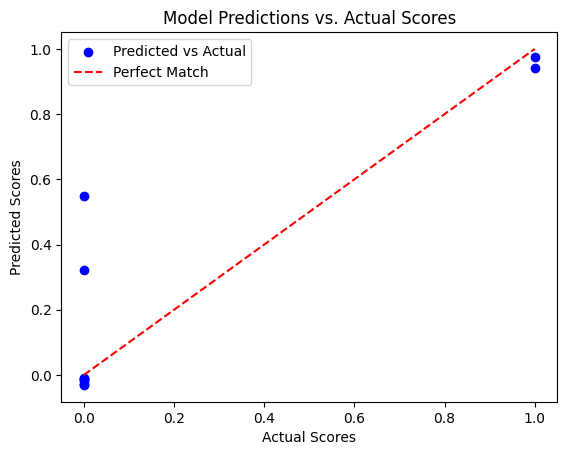

In [101]:
# Scatter plot of predictions vs. actual
import matplotlib.pyplot as plt

plt.scatter(y_val, predictions, c='blue', label='Predicted vs Actual')
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Match')  # Reference line
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.title('Model Predictions vs. Actual Scores')
plt.legend()
plt.show()

In [102]:
import cv2
import mediapipe as mp
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils

# Function to count steps based on hip movement (both sides)
def count_steps(hip_positions):
    """
    Counts the number of steps by tracking the hip movement along the x-axis.
    A step is detected when the hip changes direction.
    """
    step_count = 0
    previous_x = None
    direction = None

    for hip_x in hip_positions:
        if previous_x is not None:
            if hip_x > previous_x and direction != "right":
                step_count += 1
                direction = "right"
            elif hip_x < previous_x and direction != "left":
                step_count += 1
                direction = "left"
        previous_x = hip_x

    return step_count

# Path for the new test video
new_video_path = "/Users/danyukezz/Desktop/2 year 1 semester/team project/danya_preprocessing_sports/hurdling/stages/stage1/test_videos/1_user3.mp4"

# Extract keypoints for the new video
right_hip_positions = []
left_hip_positions = []

cap = cv2.VideoCapture(new_video_path)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to RGB for MediaPipe processing
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result = pose.process(frame_rgb)

    if result.pose_landmarks:
        landmarks = result.pose_landmarks.landmark

        # Extract relevant keypoints for step count analysis (both hips)
        right_hip_x = landmarks[mp_pose.PoseLandmark.RIGHT_HIP].x
        left_hip_x = landmarks[mp_pose.PoseLandmark.LEFT_HIP].x

        right_hip_positions.append(right_hip_x)
        left_hip_positions.append(left_hip_x)

cap.release()

# Count the steps for both hips
num_right_steps = count_steps(right_hip_positions)
num_left_steps = count_steps(left_hip_positions)

print(f"Detected Right Steps: {num_right_steps}, Left Steps: {num_left_steps}")

# Prepare data for model prediction
new_keypoints_padded = pad_sequences([[num_right_steps, num_left_steps]], 
                                     maxlen=X_train.shape[1], 
                                     padding='post', dtype='float32')

# Reshape to match model input (samples, timesteps, features)
new_keypoints_padded = new_keypoints_padded.reshape((new_keypoints_padded.shape[0], new_keypoints_padded.shape[1], 1))

# Predict score for the new video
predicted_score = model.predict(new_keypoints_padded)
print(f"Predicted Score: {predicted_score[0][0]:.2f}")

I0000 00:00:1737656524.789315 9764293 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1737656524.842579 10167066 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737656524.849729 10167077 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Detected Right Steps: 4, Left Steps: 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
Predicted Score: -0.01


In [103]:
print(X_train.shape[1])

2


In [104]:
def classify_score(prediction):
    """Classify the prediction into 0, 0.5, or 1 based on thresholds."""
    if prediction >= 0.7:
        return 1.0
    elif prediction >= 0.5:
        return 0.5
    else:
        return 0.0

In [105]:
# Predict scores on validation data
predictions = model.predict(X_val)

# Apply classification logic
classified_predictions = [classify_score(pred[0]) for pred in predictions]

# Print classified predictions vs actual scores
for i, (pred, actual) in enumerate(zip(classified_predictions, y_val)):
    print(f"Classified: {pred}, Actual: {actual}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Classified: 0.0, Actual: 0.0
Classified: 0.5, Actual: 0.0
Classified: 0.0, Actual: 0.0
Classified: 0.0, Actual: 0.0
Classified: 1.0, Actual: 1.0
Classified: 1.0, Actual: 1.0
Classified: 0.0, Actual: 0.0
Classified: 0.0, Actual: 0.0
Classified: 0.0, Actual: 0.0
Classified: 0.0, Actual: 0.0


In [106]:
import tensorflow.keras.backend as K

def weighted_mse(y_true, y_pred):
    """Weighted Mean Squared Error to prioritize true negatives."""
    weights = K.switch(y_true < 0.70, 2.0, 1.0)  # Weight true negatives higher
    return K.mean(weights * K.square(y_true - y_pred))

In [107]:
model.compile(optimizer=Adam(learning_rate=0.001), loss=weighted_mse, metrics=['mae'])

In [108]:
# Predict and classify scores
classified_predictions = [classify_score(pred[0]) for pred in model.predict(X_val)]

# Evaluate accuracy of classification
correct = sum(1 for pred, actual in zip(classified_predictions, y_val) if pred == actual)
accuracy = correct / len(y_val)

print(f"Classification Accuracy: {accuracy:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
Classification Accuracy: 0.90


In [109]:
model.save("/Users/danyukezz/Desktop/2 year 1 semester/team project/danya_preprocessing_sports/hurdling/stages/stage1/models/hurdles_stage1.keras")